In [29]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import scipy.integrate as integr

In [2]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as w
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl

In [3]:
path = os.getcwd()

In [4]:
Par = [0.8/1.42953, 8.6*2/3, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [7]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = w.Simulate_DNeg(Smpl.Sympl_DNeg, Par, -0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[0.5596244919658909, 5.733333333333333, 2.8666666666666667] [12.          3.14159265  1.57079633]
210.77240705490112


In [6]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [8]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [9]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

In [9]:
Motion2 = w.simulate_raytracer_fullpath(100, Par, initial_q, 500, 20**2, 20**2, 'RK45')

Initializing screen and calculating initial condition...
Iteration (0, 399) completed in 0.014873027801513672s.
Iteration (1, 399) completed in 0.014448165893554688s.
Iteration (2, 399) completed in 0.014101028442382812s.
Iteration (3, 399) completed in 0.01415395736694336s.
Iteration (4, 399) completed in 0.013562917709350586s.
Iteration (5, 399) completed in 0.021430015563964844s.
Iteration (6, 399) completed in 0.013828754425048828s.
Iteration (7, 399) completed in 0.014266729354858398s.
Iteration (8, 399) completed in 0.015357017517089844s.
Iteration (9, 399) completed in 0.013401031494140625s.
Iteration (10, 399) completed in 0.013108015060424805s.
Iteration (11, 399) completed in 0.015760183334350586s.
Iteration (12, 399) completed in 0.013463973999023438s.
Iteration (13, 399) completed in 0.013947248458862305s.
Iteration (14, 399) completed in 0.013590097427368164s.
Iteration (15, 399) completed in 0.014824390411376953s.
Iteration (16, 399) completed in 0.015218973159790039s.
It

Iteration (146, 399) completed in 0.015031099319458008s.
Iteration (147, 399) completed in 0.01835322380065918s.
Iteration (148, 399) completed in 0.014529943466186523s.
Iteration (149, 399) completed in 0.014428138732910156s.
Iteration (150, 399) completed in 0.014536857604980469s.
Iteration (151, 399) completed in 0.013733863830566406s.
Iteration (152, 399) completed in 0.013738870620727539s.
Iteration (153, 399) completed in 0.016595125198364258s.
Iteration (154, 399) completed in 0.012803077697753906s.
Iteration (155, 399) completed in 0.013160943984985352s.
Iteration (156, 399) completed in 0.019192934036254883s.
Iteration (157, 399) completed in 0.013189315795898438s.
Iteration (158, 399) completed in 0.013878107070922852s.
Iteration (159, 399) completed in 0.016329050064086914s.
Iteration (160, 399) completed in 0.013345003128051758s.
Iteration (161, 399) completed in 0.01728200912475586s.
Iteration (162, 399) completed in 0.013389110565185547s.
Iteration (163, 399) completed in

Iteration (291, 399) completed in 0.02152085304260254s.
Iteration (292, 399) completed in 0.01770806312561035s.
Iteration (293, 399) completed in 0.019624948501586914s.
Iteration (294, 399) completed in 0.014655828475952148s.
Iteration (295, 399) completed in 0.014612913131713867s.
Iteration (296, 399) completed in 0.015400886535644531s.
Iteration (297, 399) completed in 0.013707876205444336s.
Iteration (298, 399) completed in 0.02267909049987793s.
Iteration (299, 399) completed in 0.014567852020263672s.
Iteration (300, 399) completed in 0.014672040939331055s.
Iteration (301, 399) completed in 0.014600038528442383s.
Iteration (302, 399) completed in 0.014462947845458984s.
Iteration (303, 399) completed in 0.015612363815307617s.
Iteration (304, 399) completed in 0.0162351131439209s.
Iteration (305, 399) completed in 0.015980005264282227s.
Iteration (306, 399) completed in 0.0156710147857666s.
Iteration (307, 399) completed in 0.015075206756591797s.
Iteration (308, 399) completed in 0.02

In [10]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

In [42]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], np.zeros(Motion2[-1, 1, 0].shape, dtype=bool)))

True

In [59]:
def simulate_radius2(t_end = 100, Par = [0.43/1.42953, 1, 0.48], q0 = [6.68, np.pi, np.pi/2], Nz = 14**2, Ny = 14**2, methode = 'BDF'):
    """
    Solves the differential equations using a build in solver (solve_ivp) with
    specified method.
    Input:  - t_end: endtime of the Integration
            - Par: wormhole parameters
            - q0: position of the camera
            - Nz: number of vertical pixels
            - Ny: number of horizontal pixels
            - methode: method used for solving the ivp (standerd runge-kutta of fourth order)

    Output: - endmom: matrix with the momenta of the solution
            - endpos: matrix with the positions of the solution
    """
    print('Initializing screen and calculating initial condition...')

    # end = int(np.ceil(np.sqrt(Ny**2+Nz**2)))
    M, rho, a = Par

    S_R = np.empty((Ny,1,3))
    S_R[:,:,0] = 0.5
    S_R[:,:,1] = np.linspace(0,1,Ny).reshape(Ny,1)
    S_R[:,:,2] = 0
    S_RT = np.transpose(S_R, (2,0,1))
    print(S_RT)
    # Reading out values and determining parameters 
    S_R_sph = cart_Sph(S_RT)
    p, Cst = inn_momenta(S_R, S_R_sph, Cst_DNeg, inn_mom_DNeg, Par)
    p1, p2, p3 = p
    q1, q2, q3 = q0
    endpos = []
    endmom = []

    # Looping over all momenta
    for teller1 in range(0, len(p1)):
        row_pos = []
        row_mom = []
        start_it = time.time()
        for teller2 in range(0, len(p1[0])):

            start_it = time.time()
            initial_values = np.array([q1, q2, q3, p1[teller1][teller2], p2[teller1][teller2], p3[teller1][teller2], M, rho, a])
            # Integrates to the solution
            sol = integr.solve_ivp(diff_equations, [t_end, 0], initial_values, method = methode, t_eval=[0])
            #Reads out the data from the solution
            l_end       = sol.y[0][-1]
            phi_end     = sol.y[1][-1]
            # Correcting for phi and theta values out of bounds
            while phi_end>2*np.pi:
                phi_end = phi_end - 2*np.pi
            while phi_end<0:
                phi_end = phi_end + 2*np.pi
            theta_end   = sol.y[2][-1]
            while theta_end > np.pi:
                theta_end = theta_end - np.pi
            while theta_end < 0:
                theta_end = theta_end + np.pi
            pl_end      = sol.y[3][-1]
            pphi_end    = sol.y[4][-1]
            ptheta_end  = sol.y[5][-1]
            # adds local solution to row
            row_pos.append(np.array([l_end, phi_end, theta_end]))
            row_mom.append(np.array([pl_end, pphi_end, ptheta_end]))

        # adds row to matrix
        endpos.append(np.array(row_pos))
        endmom.append(np.array(row_mom))
        end_it = time.time()
        duration = end_it - start_it
        # print('Iteration ' + str((teller1, teller2)) + ' completed in ' + str(duration) + 's.')
    return [np.array(endmom), np.array(endpos)], [S_RT[1]]


def wormhole_with_symmetry2(t_end=100, Par=[0.43/1.42953, 1, 0.43], initialcond = [50, np.pi, np.pi/2], Nz=400, Ny=400):

    """
    One function to calculate the ray and rotate it to a full picture with the
    given parameters (used to easily run the symmetry code in other files)
    Input:  - time: initial time (backwards integration thus end time)
            - initialcond: initial conditions which take the form [l, phi, theta]
            - Nz: vertical number of pixels
            - Ny: horizontal number of pixels
            - Par: wormhole parameters [M, rho, a]
    Output: - picture: a 2D matrix containing the [l, phi, theta] value of the endpoint of each pixel
    """

    start = time.time()
    sol = simulate_radius2(t_end, Par, initialcond, Nz, Ny, methode = 'BDF')
    end = time.time()
    print('Tijdsduur = ' + str(end-start))
    p_q, D = sol
    momenta, position = p_q
    R = D[0]

    print('Rotating ray...')
    picture = Dmeg_symm_quat(np.transpose(position,(2,0,1)), initialcond, Nz, Ny, R)
    print('Ray rotated!')
    return picture

def Sph_cart(psi):
    r, phi, theta = psi
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return np.array([x,y,z])


def rotation_quat(q):
    q = q.T
    R = np.array([
        [q[0] ** 2 + q[1] ** 2 - q[2] ** 2 - q[3] ** 2, 2 * (q[1] * q[2] - q[0] * q[3]),
         2 * (q[0] * q[2] + q[1] * q[3])],

        [2 * (q[1] * q[2] + q[0] * q[3]), q[0] ** 2 - q[1] ** 2 + q[2] ** 2 - q[3] ** 2,
         2 * (q[2] * q[3] - q[0] * q[1])],

        [2 * (q[1] * q[3] - q[0] * q[2]), 2 * (q[0] * q[1] + q[2] * q[3]),
         q[0] ** 2 - q[1] ** 2 - q[2] ** 2 + q[3] ** 2]
    ])
    if R[0, 1].shape != ():
        return np.transpose(R, (2, 0, 1))
    else:
        return R

def Dmeg_symm_quat(q, q0, Nz, Ny, R):
    #input  q: q along theta = pi/2 and phi>0 with coordinates on te first axis
    #          The pixel shape should be of the form (1,Ny/2) with the pixels all being on y>0:
    #       Ni pixels
    #       q0: initial position

    #output symmetrized (3,Nz,Ny) array
    print(q.shape)
    q0_cart = Sph_cart(q0)
    S_c = screen_cart(Nz, Ny)
    S_cT = np.transpose(S_c, (2,0,1))

    S_CT_Or = S_cT - q0_cart.reshape(3,1,1)
    y, z = S_CT_Or[1:]
    r_polar = np.linalg.norm(S_CT_Or[1:], axis=0)
    alpha = np.arctan2(z,y)
    
    l_cond = q[0] > 0
    print(l_cond.shape, q[0].shape )
    inv_l_cond = ~l_cond
    q[0][inv_l_cond] = -q[0][inv_l_cond]
    q_cart = Sph_cart(q)

    tlc = np.tile(l_cond, (3,1,1))
    q_cart[tlc] +=  -np.tile(q0_cart.reshape(3,1,1), tuple([1]+list(q_cart[0].shape)))[tlc]
    
    Rot_axis = q0_cart/np.linalg.norm(q0_cart)
    q_Rotated = np.empty((3, Nz, Ny))
    lcr = np.zeros((Nz,Ny), dtype=bool)
    for j in range(Nz):
        for i in range(Ny):
            alpha_k = alpha[j,i]
            r_polar_k = r_polar[j,i]

            q = np.concatenate((
                np.cos(alpha_k/2).reshape(1),
                np.sin(alpha_k/2)*Rot_axis), axis=0
                )
            k = np.argmin(np.abs(R - r_polar_k))
            #print(q_cart[:,k,0])
            q_Rotated[:,j,i] = np.dot(rotation_quat(q), q_cart[:,k,0])
            lcr[j,i] = l_cond[k,0]
    print(q_Rotated.shape)
    lcr_inv = ~lcr
    tlcr = np.tile(lcr, (3,1,1))
    q_Rotated[tlcr] += np.tile(q0_cart.reshape(3,1,1), tuple([1]+list(q_Rotated[0].shape)))[tlcr]
    q_Rot_Sph = cart_Sph(q_Rotated)
    q_Rot_Sph[0][lcr_inv] = -q_Rot_Sph[0][lcr_inv]

    return q_Rot_Sph

In [60]:
q_scipy_symm = wormhole_with_symmetry2(100, Par, initial_q, 20**2, 20**2)

Initializing screen and calculating initial condition...
[[[0.5       ]
  [0.5       ]
  [0.5       ]
  ...
  [0.5       ]
  [0.5       ]
  [0.5       ]]

 [[0.        ]
  [0.00250627]
  [0.00501253]
  ...
  [0.99498747]
  [0.99749373]
  [1.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
Tijdsduur = 7.365052938461304
Rotating ray...
(3, 400, 1)
(400, 1) (400, 1)
(3, 400, 400)
Ray rotated!


In [62]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr NewSymm DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(q_scipy_symm, wg.Grid_constr_2D(q_scipy_symm, 11, 1, 0.05)))

True

In [36]:
M = alpha.size
q_flat = np.empty((3,M))
alpha = alpha.flatten().reshape(M,1)
r_polar = r_polar.flatten().reshape(M,1)
k = np.argmin(np.abs(R.reshape(1, int(Ny/2)) - r_polar), axis=1)
q = np.concatenate(
            np.cos(alpha/2),
            np.sin(alpha/2)*np.tile(Rot_axis,(1,M)), axis=0
            )
for i in range(M):
    q_flat[3, i] = np.dot(rotation_quat(q[i]), q_cart[:,0,k[i]])

array([0, 0])

In [38]:
np.array([[0,2],[1,3]]).flatten()

array([0, 2, 1, 3])

<IPython.core.display.Javascript object>


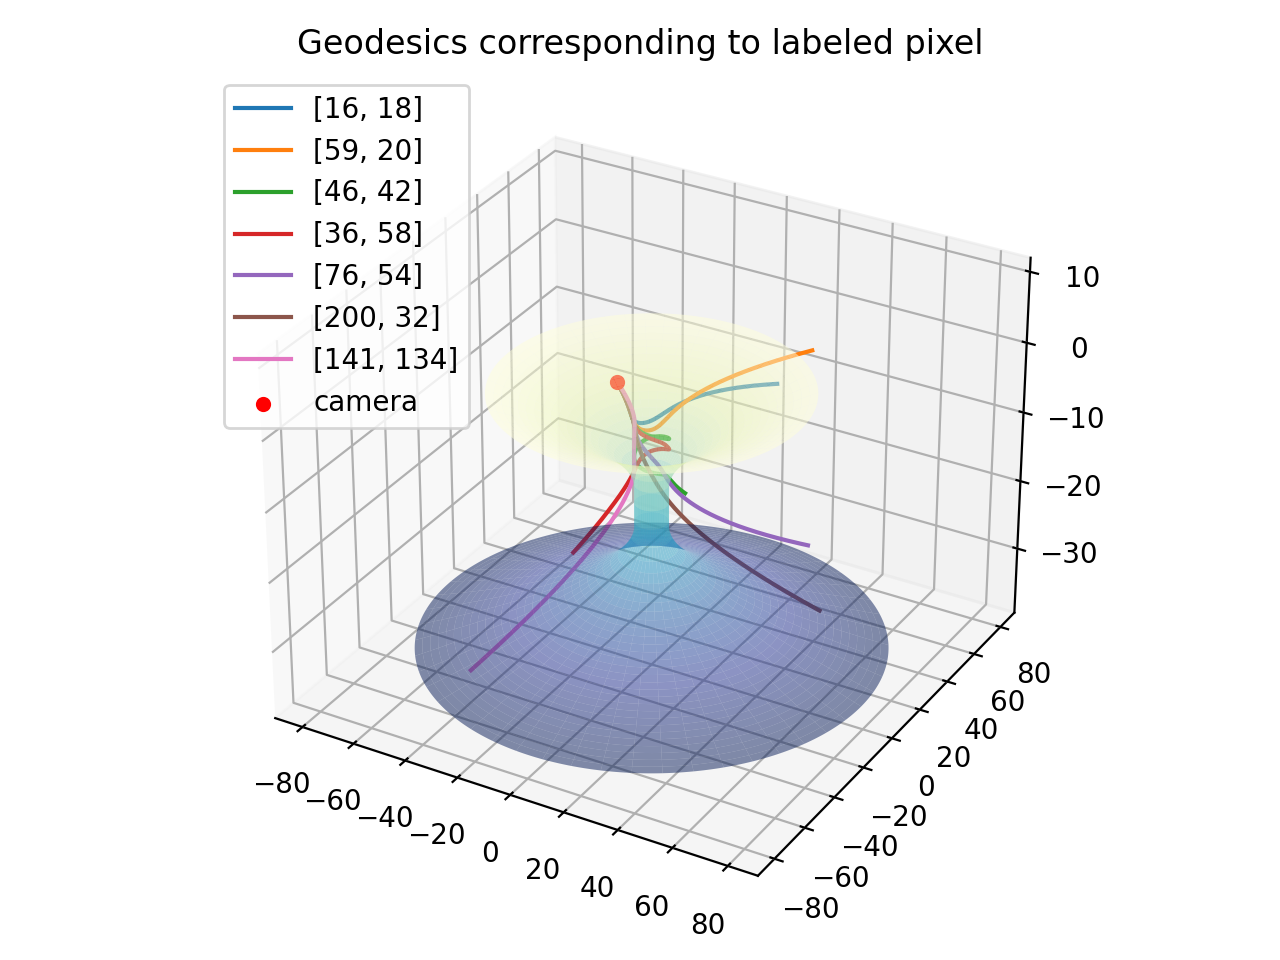

In [11]:
Geo_label = None #list of strings for labeling geodesics, turn Geo_sel to None
#Geo_Sel = None
Geo_Sel = [[16,18],[59,20],[46,42],[36,58],[76,54],[200,32],[141,134]]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [21]:
np.array(CM1).shape

(2000, 3, 20, 20)

In [12]:
CM2 = np.array([w.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


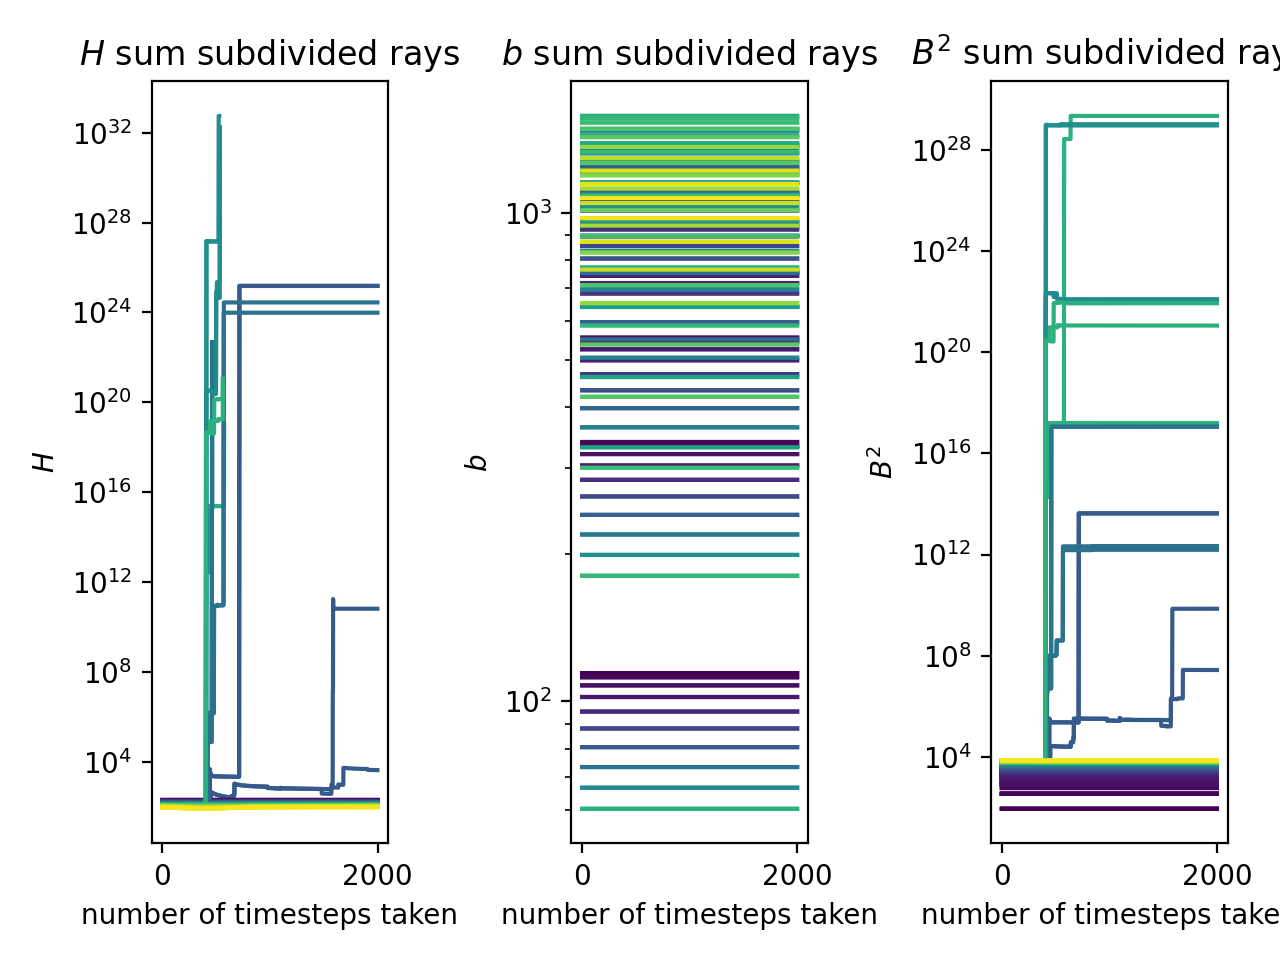

In [41]:
wg.plot_CM(CM1, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


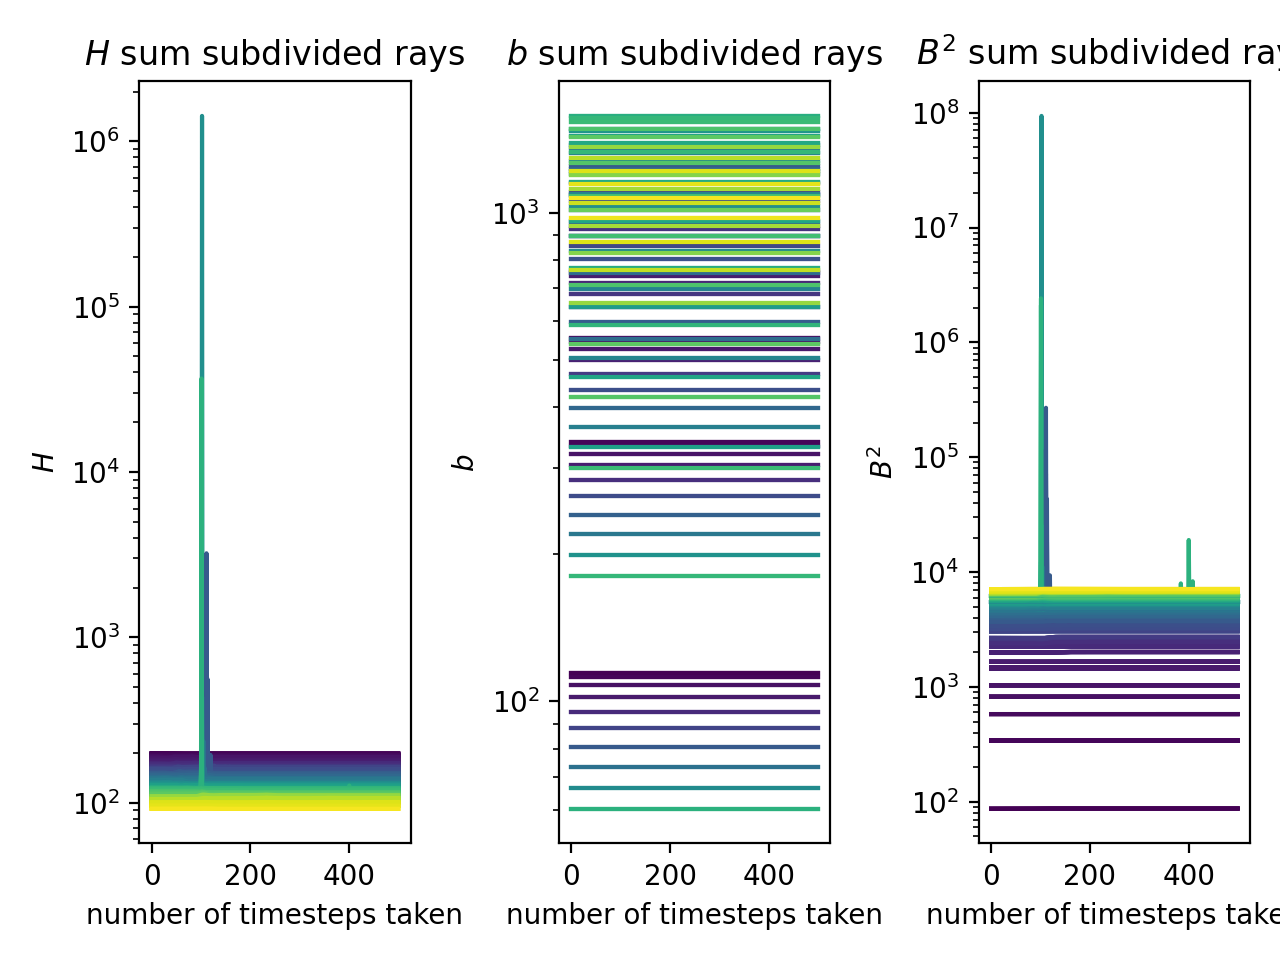

In [40]:
wg.plot_CM(CM2, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg scipy intgr."+str(Par)+" "+str(initial_q)+".png", path)

In [15]:
tuple([1] + list((2,3,4)))

(1, 2, 3, 4)